In [2]:
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import SVD, NMF, KNNWithZScore, KNNWithMeans
from surprise import AlgoBase

from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import os
# import sys
import math
import statistics
import collections

import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF, TruncatedSVD
import numpy as np
import pandas as pd

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import datetime
from datetime import datetime
from time import time
import timeit

import math

In [3]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        # self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or inner id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        # if len(lf_sp) != 4:
        #     raise Exception('''Bad line format!
        #     line_format should be space-separated and it should always specified by 
        #     "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idx = -1
        rating_idx = -1
        # timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            # elif lf_sp[c] == 'timestamp':
            #     timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        # return user_idx, item_idx, rating_idx, timestamp_idx
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    # def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating'):
        
        # user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        # timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            # timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            # timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        '''note that raw ids are in STRING format, and the iid in INTEGER format!'''
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
            
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
            
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
            
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        # self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            # self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('\nNumber of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d\n' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests
    
    def cross_validate(self, n_splits=5):

        user_ratings = self.list_users_ratings(self.rating_mat)
        len_user_ratings = {u:len(user_ratings[0]) for u in range(self.user_n)}
        user_indices = {}
        for u in range(self.user_n):
            indices = list(range(len_user_ratings[u]))
            random.shuffle(indices)
            user_indices[u] = indices

        
        user_start = {}
        user_stop = {}
        for u in range(self.user_n):
            user_start[u] = 0
            user_stop[u] = 0


        for fold_i in range(n_splits):
            train_mat = sparse.lil_matrix((self.user_n, self.item_n))
            user_tests = {}

            for u in range(self.user_n):
                user_start[u] = user_stop[u]
                user_stop += len_user_ratings[u] // n_splits
                if fold_i < len_user_ratings[u] % n_splits:
                    user_stop += 1
                
                train_set_indices = user_indices[u][:user_start[u]] + user_indices[u][user_stop[u]:]
                test_set_indices = user_indices[u][user_start[u]:user_stop[u]]

                for ir_idx in train_set_indices:
                    ir = user_ratings[u][ir_idx]
                    train_mat[u, ir[0]] = ir[1]
                
                user_tests[u] = []
                for ir_idx in test_set_indices:
                    ir = user_ratings[u][ir_idx]
                    user_tests[u].append(ir)

            yield train_mat, user_tests


In [4]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        # check here: pro_users_index consists of inner ids
        if iid_to_gender[row.uid] == 'F':
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

In [104]:
#df = pd.read_csv('data/ml-100k/udata.csv', sep=';', header=0, engine='python', names=['user', 'item', 'rating'])
#user = pd.read_csv('data/ml-100k/uuser.csv', sep=';', header=0, engine='python', names=['id', 'age', 'gender', 'occupation', 'zipcode'])
#user = user[['id', 'gender']]

In [5]:
df = pd.read_csv('data/ml-1m/ratings.dat', sep='::', header=None, engine='python', names=['user', 'item', 'rating', 'timestamp'])
user = pd.read_csv('data/ml-1m/users.dat', sep='::', header=None, engine='python', names=['id', 'gender', 'age', 'occupation', 'zipcode'])
user = user[['id', 'gender']]

In [6]:
user['is_pro'] = 0
for i, row in user.iterrows():
    if row['gender'] == 'F':
        user.loc[i, 'is_pro'] = 1

In [7]:
df = df.merge(user, left_on='user', right_on='id')

In [8]:
m_df = df[df['gender'] == 'M']
f_df = df[df['gender'] == 'F']

In [9]:
f_df.shape

(246440, 7)

In [10]:
m_df.shape

(753769, 7)

## Male is 0

In [68]:
f_df = f_df[['user', 'item', 'rating']].sample(n=25000, random_state=1)

f_df.to_csv('data/ml-100k/udata_female_sampled.csv', index=False)

In [69]:
dataset = RatingDataset()
dataset.read_from_file(data_fn='./data/ml-100k/udata_female_sampled.csv', skip_lines=1)

In [70]:
train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=5)


Number of users with some items in testset: 273
Number of ratings in trainset: 20093 	 Number of ratings in testset: 4907



In [71]:
user_ratings = dataset.list_users_ratings(train_mat)
# user_ratings[0]

tr_lst = []

for user_iid in range(dataset.user_n): 
    # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
    if user_ratings[user_iid]:
        base_rec = pd.DataFrame(user_ratings[user_iid])
        base_rec[2] = user_iid

        tr_lst.append(base_rec[[2,0,1]])
    

train_df = pd.concat(tr_lst, ignore_index=True)
train_df.columns = ['user','item','rating']
# train_df.head()

In [72]:
# test set to a dataframe
test_lst = []

for uiid in test_mat.keys():
    base_rec = pd.DataFrame(test_mat[uiid])
    base_rec[2] = uiid
    test_lst.append(base_rec[[2,0,1]])


test_df = pd.concat(test_lst, ignore_index=True)
test_df.columns = ['user','item','rating']
# test_df.head()

In [73]:
reader = Reader(rating_scale=(1, 5))

# got the best(lowest) results of 0.86
svd_sup = SVD(n_epochs = 150, n_factors = 10, lr_all=0.05, reg_all=0.1, verbose = False, random_state=41023)

In [74]:
testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

train_sup = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader).build_full_trainset()
svd_sup.fit(train_sup)
preds = svd_sup.test(testset)
rmse = accuracy.rmse(preds, verbose=False)

In [75]:
rmse

1.0676043341078647

## Add male with size k% of female

In [17]:
all_addmale_female_rmse_lst = []
for _ in range(5):
    female_rmse_lst = []
    for k in range(5,105,5):
        # print(f"Female is {k}% of training set.")
        f_df_sampled = f_df[['user', 'item', 'rating']].sample(n=int(100000), random_state=1)
        m_df_sampled = m_df[['user', 'item', 'rating']].sample(n=int(100000*k/100), random_state=1)
    
        df_sampled = pd.concat([m_df_sampled[:], f_df_sampled[:]]).sample(frac=1, axis=0).reset_index(drop=True)
        df_sampled.to_csv('data/ml-1m/udata_sampled.csv', index=False)

        dataset = RatingDataset()
        dataset.read_from_file(data_fn='./data/ml-1m/udata_sampled.csv', skip_lines=1)

        pro_users_index = []
        unpro_users_index = []

        user_copy = user.copy()
        user_copy['iid'] = 0.1


        skip_c = 0

        for i, row in user_copy[['id', 'is_pro']].iterrows():
            try: 
                # user id to inner_id (index)
                u_index = dataset.user_to_iid[str(row['id'])]
                # print(row['id'], u_index, dataset.user_to_ID[u_index])

                # just add the inner id (index) to the user dataframe
                user_copy.loc[user_copy['id'] == row['id'], 'iid'] = u_index


                if row['is_pro'] == 1:
                    # pro_users_id.append(row['id'])
                    pro_users_index.append(u_index)

                else:
                    # unpro_users_id.append(row['id'])
                    unpro_users_index.append(u_index)
            except KeyError as err:
                skip_c += 1
        
        

        #print('users skipped', skip_c, '\n')
        #print('protected users', len(pro_users_index))
        #print('unprotected users', len(unpro_users_index))
        #print()

        user_copy = user_copy[user_copy['iid']!=0.1]
        iid_to_gender = dict(zip(user_copy.iid, user_copy.gender))
        id_to_gender = dict(zip(user_copy.id, user_copy.gender))

        train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=5)
        user_ratings = dataset.list_users_ratings(train_mat)
        # user_ratings[0]

        tr_lst = []

        for user_iid in range(dataset.user_n): 
            # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
            if user_ratings[user_iid]:
                base_rec = pd.DataFrame(user_ratings[user_iid])
                base_rec[2] = user_iid

                tr_lst.append(base_rec[[2,0,1]])
    

        train_df = pd.concat(tr_lst, ignore_index=True)
        train_df.columns = ['user','item','rating']

        # test set to a dataframe
        test_lst = []

        for uiid in test_mat.keys():
            base_rec = pd.DataFrame(test_mat[uiid])
            base_rec[2] = uiid
            test_lst.append(base_rec[[2,0,1]])


        test_df = pd.concat(test_lst, ignore_index=True)
        test_df.columns = ['user','item','rating']

        reader = Reader(rating_scale=(1, 5))

        svd_sup = SVD(n_epochs = 150, n_factors = 10, lr_all=0.05, reg_all=0.1, verbose = False, random_state=41023)

        testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

        train_sup = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader).build_full_trainset()
        svd_sup.fit(train_sup)
        preds = svd_sup.test(testset)
        #rmse = accuracy.rmse(preds, verbose=False)
        pro_, unpro_ = seperate_preds(preds)
        #print(f"Male rmse: {accuracy.rmse(unpro_, verbose=False)}")
        #print(f"Female rmse: {accuracy.rmse(pro_, verbose=False)}")
        #print("------------------")
        female_rmse_lst.append(accuracy.rmse(pro_, verbose=False))
    all_addmale_female_rmse_lst.append(female_rmse_lst)


Number of users with some items in testset: 1941
Number of ratings in trainset: 85428 	 Number of ratings in testset: 19572


Number of users with some items in testset: 2387
Number of ratings in trainset: 89782 	 Number of ratings in testset: 20218


Number of users with some items in testset: 2821
Number of ratings in trainset: 93951 	 Number of ratings in testset: 21049


Number of users with some items in testset: 3156
Number of ratings in trainset: 98073 	 Number of ratings in testset: 21927


Number of users with some items in testset: 3442
Number of ratings in trainset: 102191 	 Number of ratings in testset: 22809


Number of users with some items in testset: 3688
Number of ratings in trainset: 106252 	 Number of ratings in testset: 23748


Number of users with some items in testset: 3905
Number of ratings in trainset: 110288 	 Number of ratings in testset: 24712


Number of users with some items in testset: 4107
Number of ratings in trainset: 114282 	 Number of ratings in test

In [18]:
all_addfemale_female_rmse_lst = []
for _ in range(5):
    female_rmse_lst = []
    for k in range(5,105,5):
        # print(f"Female is {k}% of training set.")
        f_df_sampled = f_df[['user', 'item', 'rating']].sample(n=int(200000), random_state=1)
        fixed_f_df = f_df_sampled.iloc[:100000]
        pool_f_df = f_df_sampled.iloc[100000:]
        pool_f_df_sampled = pool_f_df[['user', 'item', 'rating']].sample(n=int(100000*k/100), random_state=1)
    
        df_sampled = pd.concat([pool_f_df_sampled[:], fixed_f_df[:]]).sample(frac=1, axis=0).reset_index(drop=True)
        df_sampled.to_csv('data/ml-1m/udata_sampled.csv', index=False)

        dataset = RatingDataset()
        dataset.read_from_file(data_fn='./data/ml-1m/udata_sampled.csv', skip_lines=1)

        pro_users_index = []
        unpro_users_index = []

        user_copy = user.copy()
        user_copy['iid'] = 0.1


        skip_c = 0

        for i, row in user_copy[['id', 'is_pro']].iterrows():
            try: 
                # user id to inner_id (index)
                u_index = dataset.user_to_iid[str(row['id'])]
                # print(row['id'], u_index, dataset.user_to_ID[u_index])

                # just add the inner id (index) to the user dataframe
                user_copy.loc[user_copy['id'] == row['id'], 'iid'] = u_index


                if row['is_pro'] == 1:
                    # pro_users_id.append(row['id'])
                    pro_users_index.append(u_index)

                else:
                    # unpro_users_id.append(row['id'])
                    unpro_users_index.append(u_index)
            except KeyError as err:
                skip_c += 1
        
        

        #print('users skipped', skip_c, '\n')
        #print('protected users', len(pro_users_index))
        #print('unprotected users', len(unpro_users_index))
        #print()

        user_copy = user_copy[user_copy['iid']!=0.1]
        iid_to_gender = dict(zip(user_copy.iid, user_copy.gender))
        id_to_gender = dict(zip(user_copy.id, user_copy.gender))

        train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=5)
        user_ratings = dataset.list_users_ratings(train_mat)
        # user_ratings[0]

        tr_lst = []

        for user_iid in range(dataset.user_n): 
            # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
            if user_ratings[user_iid]:
                base_rec = pd.DataFrame(user_ratings[user_iid])
                base_rec[2] = user_iid

                tr_lst.append(base_rec[[2,0,1]])
    

        train_df = pd.concat(tr_lst, ignore_index=True)
        train_df.columns = ['user','item','rating']

        # test set to a dataframe
        test_lst = []

        for uiid in test_mat.keys():
            base_rec = pd.DataFrame(test_mat[uiid])
            base_rec[2] = uiid
            test_lst.append(base_rec[[2,0,1]])


        test_df = pd.concat(test_lst, ignore_index=True)
        test_df.columns = ['user','item','rating']

        reader = Reader(rating_scale=(1, 5))

        svd_sup = SVD(n_epochs = 150, n_factors = 10, lr_all=0.05, reg_all=0.1, verbose = False, random_state=41023)

        testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

        train_sup = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader).build_full_trainset()
        svd_sup.fit(train_sup)
        preds = svd_sup.test(testset)
        #rmse = accuracy.rmse(preds, verbose=False)
        pro_, unpro_ = seperate_preds(preds)
        #print(f"Male rmse: {accuracy.rmse(unpro_, verbose=False)}")
        #print(f"Female rmse: {accuracy.rmse(pro_, verbose=False)}")
        #print("------------------")
        female_rmse_lst.append(accuracy.rmse(pro_, verbose=False))
    all_addfemale_female_rmse_lst.append(female_rmse_lst)


Number of users with some items in testset: 1706
Number of ratings in trainset: 84699 	 Number of ratings in testset: 20301


Number of users with some items in testset: 1707
Number of ratings in trainset: 88678 	 Number of ratings in testset: 21322


Number of users with some items in testset: 1707
Number of ratings in trainset: 92682 	 Number of ratings in testset: 22318


Number of users with some items in testset: 1707
Number of ratings in trainset: 96691 	 Number of ratings in testset: 23309


Number of users with some items in testset: 1708
Number of ratings in trainset: 100684 	 Number of ratings in testset: 24316


Number of users with some items in testset: 1709
Number of ratings in trainset: 104669 	 Number of ratings in testset: 25331


Number of users with some items in testset: 1709
Number of ratings in trainset: 108677 	 Number of ratings in testset: 26323


Number of users with some items in testset: 1709
Number of ratings in trainset: 112693 	 Number of ratings in test

In [19]:
male_result = np.mean(np.array(all_addmale_female_rmse_lst), axis=0)
female_result = np.mean(np.array(all_addfemale_female_rmse_lst), axis=0)

Text(0, 0.5, 'RMSE of female user')

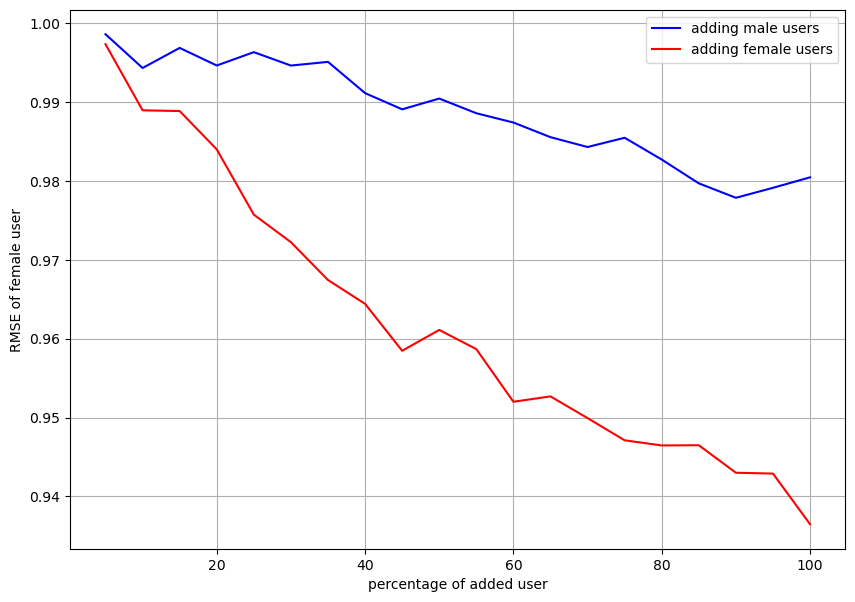

In [22]:
fig, ax = plt.subplots(figsize=(10,7))
x = [k for k in range(5,105,5)]
ax.plot(x, male_result, color='b', label='adding male users')
ax.plot(x, female_result, color='r', label='adding female users')

ax.grid(True)
legend = ax.legend(loc='best')

plt.xlabel('percentage of added user')
plt.ylabel('RMSE of female user')

In [162]:
result = np.array(all_female_rmse_lst)
result_std = np.std(result, axis=0)
result_mean = np.mean(result, axis=0)
result_ci = 1.95 * result_std / np.sqrt(5)
result_ci_low = result_mean - result_ci
result_ci_high = result_mean + result_ci

Text(0, 0.5, 'RMSE of female user')

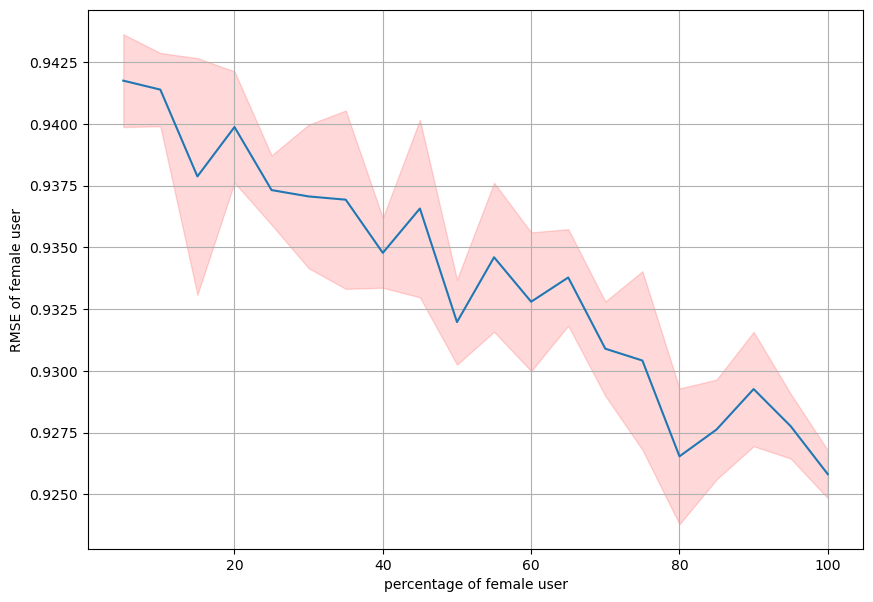

In [164]:
fig, ax = plt.subplots(figsize=(10,7))
x = [k for k in range(5,105,5)]
ax.plot(x, result_mean)

ax.fill_between(x, result_ci_low, result_ci_high, color='r', alpha=0.15)

ax.grid(True)
plt.xlabel('percentage of female user')
plt.ylabel('RMSE of female user')
#plt.savefig('./plots/20240417/female_rmse_over_percentage_ml1m.png', dpi=300)